In [23]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
import pydot
from IPython.display import Image

In [24]:
titanic=pd.read_csv("train.csv")
titanic[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
titanic["Age"]= titanic["Age"].fillna(titanic["Age"].median())

In [26]:
titanic.loc[titanic["Sex"]=="male" , "Sex"] = 0

In [27]:
titanic.loc[titanic["Sex"]== "female","Sex"] =1
titanic["Embarked"]= titanic["Embarked"].fillna("S")
titanic.loc[titanic["Embarked"]== "S","Embarked"] =0
titanic.loc[titanic["Embarked"]== "C","Embarked"] =1
titanic.loc[titanic["Embarked"]== "Q","Embarked"] =2

In [28]:
def classification_model(model, data, predictors, outcome):
    #Fit the model:
    mod = model.fit(data[predictors],data[outcome])
  
    #Make predictions on training set:
    predictions = model.predict(data[predictors])
  
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print "Accuracy : %s" % "{0:.3%}".format(accuracy)
    
    
    
    precision = metrics.precision_recall_fscore_support(data[outcome], predictions, average = 'binary', warn_for=('precision', 'recall', 'f-score') )
    print(precision)
    
    
    
    #Perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])
    
        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]
    
        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)
    
        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    #print predictions
   
    print "Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error))

    #Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome]) 
    
    #now making submission based on test file updated 6/6/16
    submission_dummy = pd.DataFrame({
        "PassengerId": titanic["PassengerId"],
        "Survived": predictions
            })
    submission_dummy.to_csv("kaggle_dummy.csv", index=False)
    #print submission
    #submission.to_csv("kaggle.csv", index=False)

In [29]:
outcome_var = 'Survived'
model = LogisticRegression()
predictor_var = ['Age']
classification_model(model, titanic,predictor_var,outcome_var)

Accuracy : 61.616%
(0.0, 0.0, 0.0, None)
Cross-Validation Score : 61.610%


In [30]:
outcome_var = 'Survived'
model = LogisticRegression()
predictor_var = ['Sex','Fare','Age']
classification_model(model, titanic,predictor_var,outcome_var)

Accuracy : 78.339%
(0.73065015479876161, 0.6900584795321637, 0.7097744360902255, None)
Cross-Validation Score : 78.224%


In [31]:
outcome_var = 'Survived'
model = LogisticRegression()
predictor_var = ['Sex',  'Fare', 'Age']
classification_model(model, titanic,predictor_var,outcome_var)

Accuracy : 78.339%
(0.73065015479876161, 0.6900584795321637, 0.7097744360902255, None)
Cross-Validation Score : 78.224%


In [32]:
model.coef_

array([[ 2.31530086,  0.01156839, -0.01149689]])

In [33]:
#decision trees with default val
model = DecisionTreeClassifier()
predictor_var= ['Sex', 'Fare', 'Age', 'Pclass','SibSp']
classification_model(model, titanic, predictor_var, outcome_var)
model.feature_importances_

Accuracy : 97.868%
(0.99088145896656532, 0.95321637426900585, 0.97168405365126675, None)
Cross-Validation Score : 78.120%


array([ 0.31194178,  0.27556065,  0.24692254,  0.11874821,  0.04682682])

Accuracy : 85.522%
(0.87632508833922262, 0.72514619883040932, 0.79359999999999997, None)
Cross-Validation Score : 83.166%


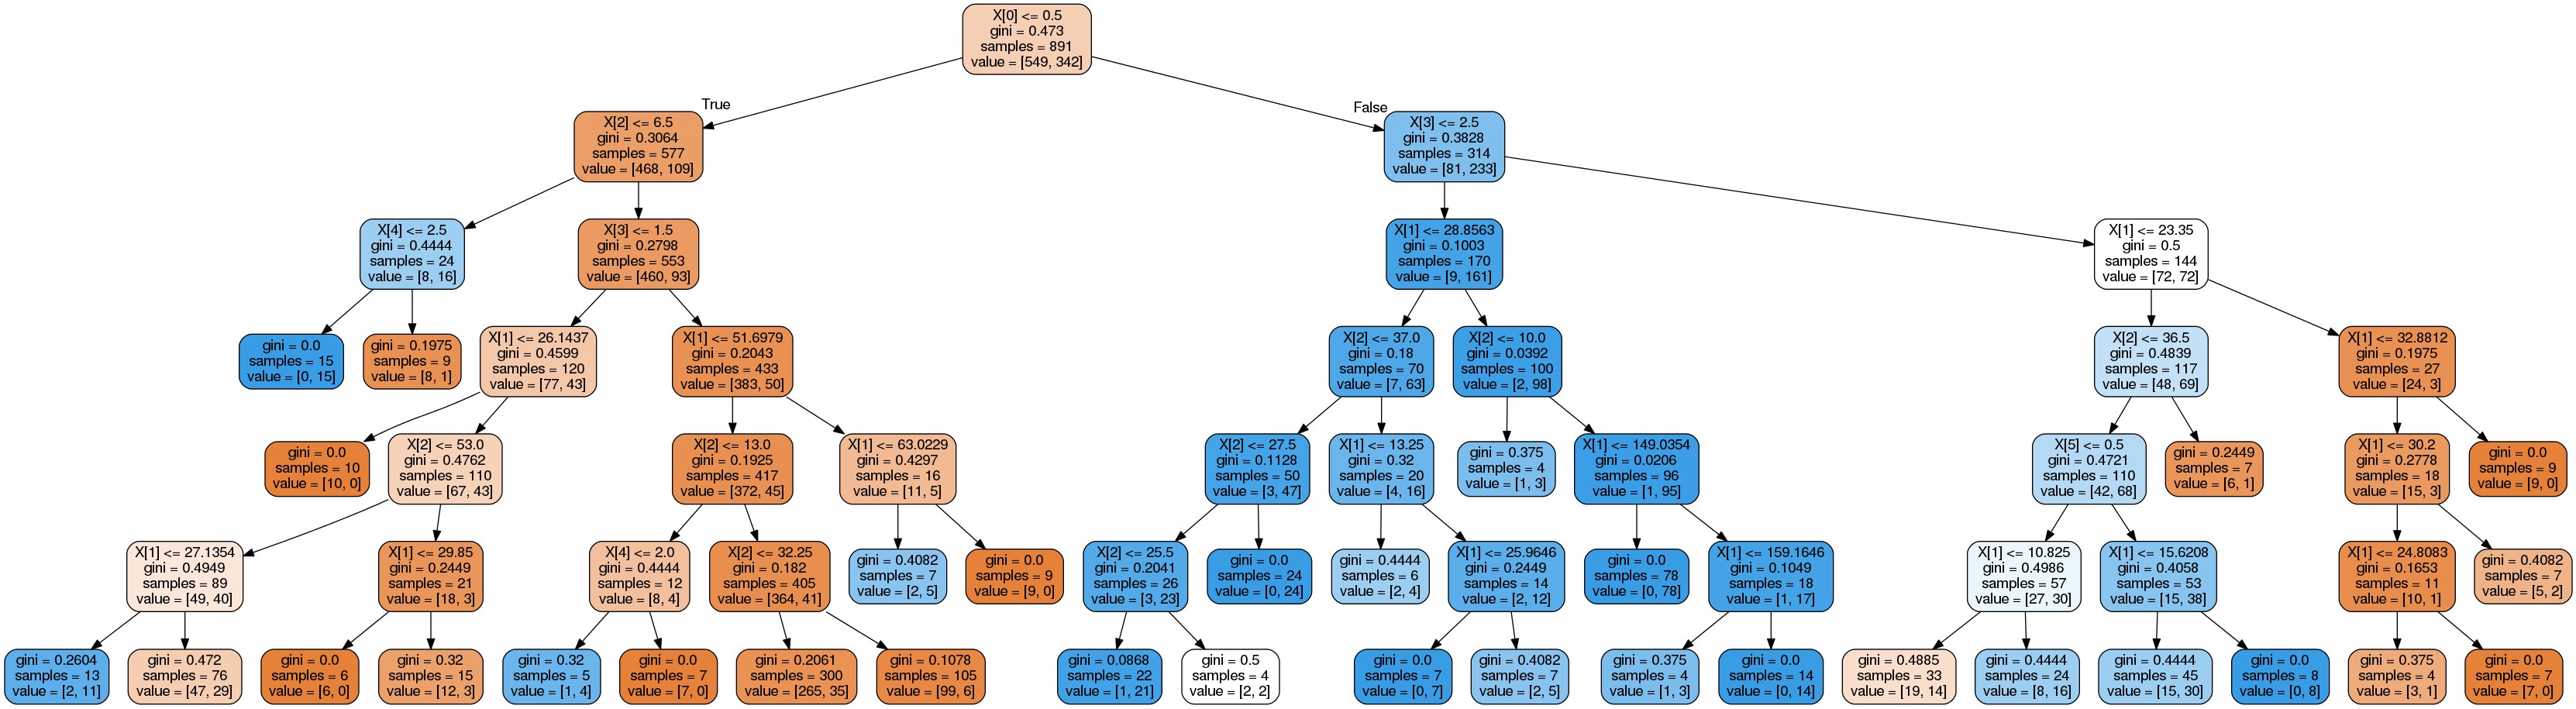

In [37]:
#decision trees with tuning
model = DecisionTreeClassifier(max_depth= 6, min_samples_split=10, min_samples_leaf=4)
predictor_var= ['Sex', 'Fare', 'Age', 'Pclass','SibSp','Embarked']
classification_model(model, titanic, predictor_var, outcome_var)
import sklearn
import sklearn.tree
clf = DecisionTreeClassifier(max_depth= 6, min_samples_split=10, min_samples_leaf=4)
clf.fit(titanic[predictor_var], titanic[outcome_var])
predictions = clf.predict(data[predictors])

with open('tree_2'+'.dot','w') as dotfile:
    sklearn.tree.export_graphviz(clf,dotfile,filled=True, rounded=True)
(graph,) = pydot.graph_from_dot_file('tree_2.dot')
graph.write_png('ans.png')

Image(filename='ans.png')

In [40]:
model = RandomForestClassifier(n_estimators=100,max_depth=10, min_samples_split=4, min_samples_leaf=3)
predictor_var= ['Sex', 'Fare', 'Age', 'Pclass','SibSp','Embarked']
classification_model(model, titanic, predictor_var, outcome_var)

Accuracy : 88.889%
(0.90099009900990101, 0.79824561403508776, 0.84651162790697676, None)
Cross-Validation Score : 82.495%


In [41]:
from sklearn.ensemble import   GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=25, min_samples_split= 4, min_samples_leaf= 2, max_depth= 3)
predictor_var = ['Sex', 'Fare','Fare','Pclass','SibSp']
classification_model(model, titanic, predictor_var, outcome_var)

Accuracy : 83.838%
(0.875, 0.67543859649122806, 0.76237623762376239, None)
Cross-Validation Score : 80.359%


In [42]:
titanic_test = pd.read_csv("test.csv")
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2
model = DecisionTreeClassifier(max_depth= 6, min_samples_split=10, min_samples_leaf=4)
predictor_var= ['Sex', 'Fare', 'Age', 'Pclass','SibSp','Embarked']
outcome_var = 'Survived'
classification_model(model, titanic, predictor_var, outcome_var)

                     
predictions = model.predict(titanic_test[predictor_var])
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
          })
#print submission
#print predictions
submission.to_csv("kaggle_final_titanic.csv", index=False)

Accuracy : 85.522%
(0.87632508833922262, 0.72514619883040932, 0.79359999999999997, None)
Cross-Validation Score : 83.166%


In [87]:
#decision trees with tuning
model = DecisionTreeClassifier(max_depth= 6, min_samples_split=10, min_samples_leaf=4)
predictor_var= ['Sex', 'Fare', 'Age', 'Pclass','SibSp','Embarked']
classification_model(model, titanic, predictor_var, outcome_var)
import sklearn
import sklearn.tree
clf = DecisionTreeClassifier(max_depth= 6, min_samples_split=10, min_samples_leaf=4)
clf.fit(titanic[predictor_var], titanic[outcome_var])
predictions = clf.predict(titanic[predictor_var])



d = {'predicted': predictions, 'actual': titanic['Survived'], 'name': titanic['Name']}
df = pd.DataFrame(data=d)

Accuracy : 85.522%
(0.87632508833922262, 0.72514619883040932, 0.79359999999999997, None)
Cross-Validation Score : 83.166%


In [102]:
#if df['predicted'][2] != df['actual'][2]:
#    print(df['name'])
for i in range(0, len(df)):

    if df['actual'][i] != df['predicted'][i]:
        print(df['name'][i])
        

Heikkinen, Miss. Laina
Williams, Mr. Charles Eugene
Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)
Beesley, Mr. Lawrence
Sloper, Mr. William Thompson
Palsson, Miss. Torborg Danira
Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)
Mamee, Mr. Hanna
Vander Planke, Miss. Augusta Maria
Arnold-Franchi, Mrs. Josef (Josefine Franchi)
Woolner, Mr. Hugh
Moubarek, Master. Gerios
Andersson, Miss. Erna Alexandra
Sheerlinck, Mr. Jan Baptist
Greenfield, Mr. William Bertram
Salkjelsvik, Miss. Anna Kristine
Moss, Mr. Albert Johan
Moran, Miss. Bertha
Zabour, Miss. Hileni
Attalah, Miss. Malake
Madsen, Mr. Fridtjof Arne
Boulos, Mrs. Joseph (Sultana)
Nysten, Miss. Anna Sofia
Andersson, Mr. August Edvard ("Wennerstrom")
Ling, Mr. Lee
Isham, Miss. Ann Elizabeth
Andersen-Jensen, Miss. Carla Christine Nielsine
Yrois, Miss. Henriette ("Mrs Harbeck")
Cohen, Mr. Gurshon "Gus"
Albimona, Mr. Nassef Cassem
Blank, Mr. Henry
Honkanen, Miss. Eliina
Sunderland, Mr. Victor Francis
Hoyt, Mr. Frederick Max